In [1]:
import os, sys
# add parent directory
sys.path.append('..')

# Basic Imports

In [2]:
%matplotlib nbagg
import matplotlib.pyplot as plt
from matplotlib.image import AxesImage
from PIL import Image
import numpy as np

from keras import backend as K

import tensorflow as tf

from networks.dextr import DEXTR
from mypath import Path
from helpers import helpers as helpers

C:\Miniconda3\envs\qbi2018\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


## Parameters
Here we specify the settings and name of the model to load

In [3]:
modelName = 'dextr_pascal-sbd'
pad = 50
thres = 0.8
gpu_id = 0

In [4]:
net = DEXTR(nb_classes=1, resnet_layers=101, input_shape=(512, 512), weights=modelName,
            num_input_channels=4, classifier='psp', sigmoid=True)
#  Read image and click the points
image = np.array(Image.open('../ims/dog-cat.jpg'))

Building network based on ResNet 101 and PSP module expecting inputs of shape (512, 512) predicting 1 classes
PSP module will interpolate to a final feature map size of (64, 64)
Loading weights from H5 file.


# Notebook Interface
Since ```plt.ginput``` does not work in jupyter notebooks we make a hacky callback version using the `button_press_event`

In [13]:
def ginput_callback(fig, ax, n_points, finish_func, loop = True):
    global pt_list, last_event, callback_id
    callback_id = 0
    pt_list = []
    old_title = ax.get_title()
    def on_click(event):
        global pt_list, last_event, callback_id
        last_event = event
        pt_list += [(event.xdata, event.ydata)]
        ax.plot(event.xdata, event.ydata, 'r+')
        ax.set_title('Clicked Points: {}/{}'.format(len(pt_list), n_points))
        fig.canvas.draw()
        if len(pt_list)==n_points:
            ax.set_title('Processing...')
            fig.canvas.draw()
            finish_func(pt_list)
            fig.canvas.mpl_disconnect(callback_id)
            ax.set_title(old_title)
            fig.canvas.draw()
            if loop:
                ginput_callback(fig, ax, n_points, finish_func, loop = loop)
    callback_id = fig.canvas.mpl_connect('button_press_event', on_click)
    ax.set_title('Clicked Points: {}/{}'.format(len(pt_list), n_points))

# Run the Demo
Here we run the demo on the sample image, for every 4 clicks a new segmentation will be made

<IPython.core.display.Javascript object>


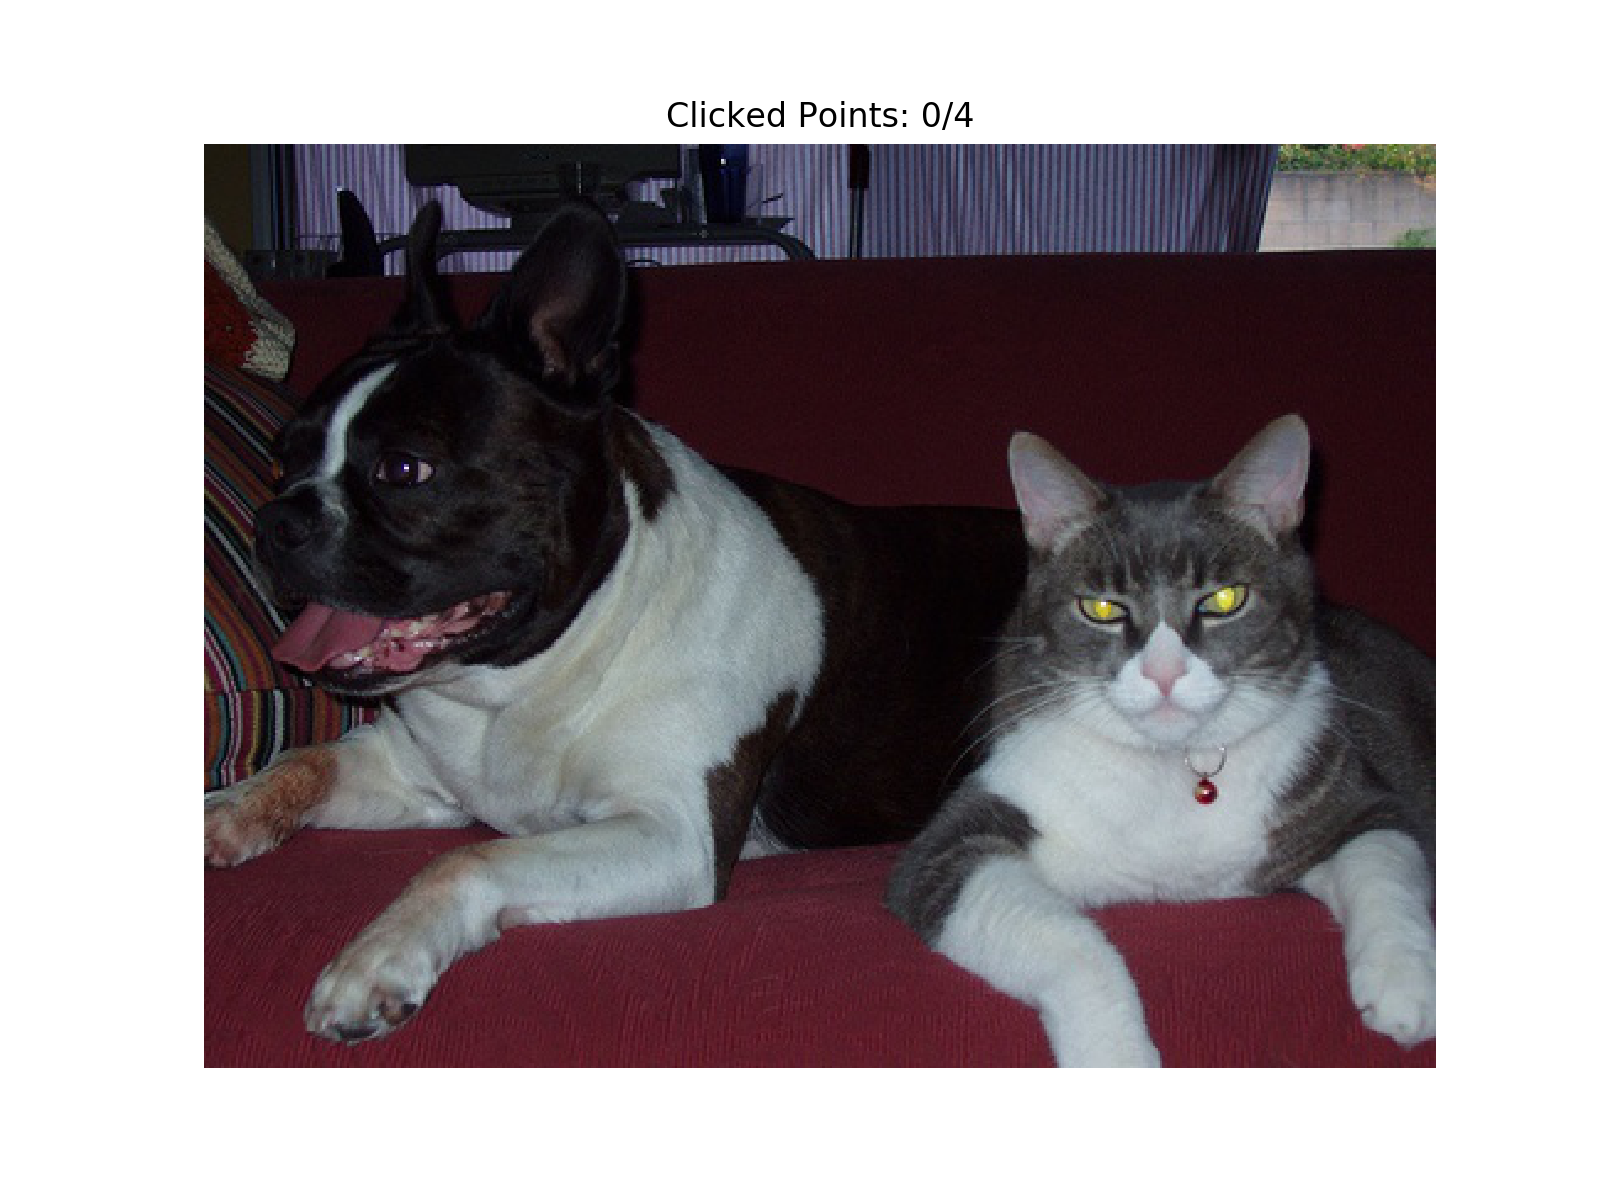

In [19]:
fig, ax1 = plt.subplots(1,1, figsize = (8,6))
ax1.set_title('click on points', picker=True)
ax1.set_ylabel('ylabel', picker=True)
ax1.imshow(image, picker = True)
ax1.set_aspect(1.0)
ax1.axis('off')
ax1.set_title('Click the four extreme points of the objects\nHit enter when done (do not close the window)')
results = []

def run_model(in_pts):
    extreme_points_ori = np.array(in_pts).astype(np.int)

    #  Crop image to the bounding box from the extreme points and resize
    bbox = helpers.get_bbox(image, points=extreme_points_ori, pad=pad, zero_pad=True)
    crop_image = helpers.crop_from_bbox(image, bbox, zero_pad=True)
    resize_image = helpers.fixed_resize(crop_image, (512, 512)).astype(np.float32)

    #  Generate extreme point heat map normalized to image values
    extreme_points = extreme_points_ori - [np.min(extreme_points_ori[:, 0]), np.min(extreme_points_ori[:, 1])] + [pad,
                                                                                                                  pad]
    extreme_points = (512 * extreme_points * [1 / crop_image.shape[1], 1 / crop_image.shape[0]]).astype(np.int)
    extreme_heatmap = helpers.make_gt(resize_image, extreme_points, sigma=10)
    extreme_heatmap = helpers.cstm_normalize(extreme_heatmap, 255)

    #  Concatenate inputs and convert to tensor
    input_dextr = np.concatenate((resize_image, extreme_heatmap[:, :, np.newaxis]), axis=2)

    # Run a forward pass
    pred = net.model.predict(input_dextr[np.newaxis, ...])[0, :, :, 0]
    result = helpers.crop2fullmask(pred, bbox, im_size=image.shape[:2], zero_pad=True, relax=pad) > thres

    results.append(result)

    # Plot the results
    ax1.imshow(helpers.overlay_masks(image / 255, results))
    ax1.plot(extreme_points_ori[:, 0], extreme_points_ori[:, 1], 'gx')

ginput_callback(fig, ax1, 4, run_model, loop = True)